In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torchsummary import summary
import torchvision.models as models
import torchvision.transforms.functional as ff
import torchvision.datasets as dsets
from PIL import Image
import itertools
%matplotlib inline

In [8]:
import copy
import os
import shutil

import numpy as np
import torch


def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path)


def cuda_devices(gpu_ids):
    gpu_ids = [str(i) for i in gpu_ids]
    os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(gpu_ids)


def cuda(xs):
    if torch.cuda.is_available():
        if not isinstance(xs, (list, tuple)):
            return xs.cuda()
        else:
            return [x.cuda() for x in xs]
    else:
        return xs


def save_checkpoint(state, save_path, is_best=False, max_keep=None):
    # save checkpoint
    torch.save(state, save_path)
#     print('saved')

    # deal with max_keep
    save_dir = os.path.dirname(save_path)
    list_path = os.path.join(save_dir, 'latest_checkpoint')

    save_path = os.path.basename(save_path)
    if os.path.exists(list_path):
        with open(list_path) as f:
            ckpt_list = f.readlines()
            ckpt_list = [save_path + '\n'] + ckpt_list
    else:
        ckpt_list = [save_path + '\n']
        
    print(ckpt_list)

    if max_keep is not None:
        for ckpt in ckpt_list[max_keep:]:
            ckpt = os.path.join(save_dir, ckpt[:-1])
            if os.path.exists(ckpt):
                os.remove(ckpt)
        ckpt_list[max_keep:] = []

    with open(list_path, 'w') as f:
        f.writelines(ckpt_list)

    # copy best
    if is_best:
        shutil.copyfile(save_path, os.path.join(save_dir, 'best_model.ckpt'))
        
def save_checkpoint_per_epoch(state, save_path, epoch, max_keep=1, is_best=False):
    # save checkpoint
    torch.save(state, save_path)
#     print('saved')

    # deal with max_keep
    save_dir = os.path.dirname(save_path)
    list_path = os.path.join(save_dir, 'latest_checkpoint_epoch_{}'.format(str(epoch)))
    
    absolute_latest_path = os.path.join(save_dir, 'latest_checkpoint')

    save_path = os.path.basename(save_path)
    if os.path.exists(list_path):
        with open(list_path) as f:
            ckpt_list = f.readlines()
            ckpt_list = [save_path + '\n'] + ckpt_list
    else:
        ckpt_list = [save_path + '\n']

    if max_keep is not None:
        for ckpt in ckpt_list[max_keep:]:
            ckpt = os.path.join(save_dir, ckpt[:-1])
            if os.path.exists(ckpt):
                os.remove(ckpt)
        ckpt_list[max_keep:] = []

    with open(list_path, 'w') as f:
        f.writelines(ckpt_list)
        
    with open(absolute_latest_path, 'w') as f:
        f.write(save_path)
    

    # copy best
    if is_best:
        shutil.copyfile(save_path, os.path.join(save_dir, 'best_model.ckpt'))


def load_checkpoint(ckpt_dir_or_file, map_location=None, load_best=False):
    if os.path.isdir(ckpt_dir_or_file):
        if load_best:
            ckpt_path = os.path.join(ckpt_dir_or_file, 'best_model.ckpt')
        else:
            with open(os.path.join(ckpt_dir_or_file, 'latest_checkpoint')) as f:
                ckpt_path = os.path.join(ckpt_dir_or_file, f.readline()[:-1])
    else:
        ckpt_path = ckpt_dir_or_file
    print(ckpt_path)
    ckpt = torch.load(ckpt_path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % ckpt_path)
    return ckpt


def reorganize(dataset_dir):
    dirs = {}
    dirs['trainA'] = os.path.join(dataset_dir, 'link_trainA')
    dirs['trainB'] = os.path.join(dataset_dir, 'link_trainB')
    dirs['testA'] = os.path.join(dataset_dir, 'link_testA')
    dirs['testB'] = os.path.join(dataset_dir, 'link_testB')
    mkdir(list(dirs.values()))

    for key in dirs:
        try:
            os.remove(os.path.join(dirs[key], '0'))
        except:
            pass
        os.symlink(os.path.abspath(os.path.join(dataset_dir, key)),
                   os.path.join(dirs[key], '0'))

    return dirs

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)
        
def truncated_normal_(tensor, mean=0, std=1):
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)
    
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [9]:
def conv_general(input_dim, output_dim, kernel_size, stride, padding=0,
                 norm=nn.InstanceNorm2d, normalize=True, activate=True, relu_factor=0):
    ops = list()
    conv_layer = nn.Conv2d(input_dim, output_dim, kernel_size, stride, padding, bias=False)
#     truncated_normal_(conv_layer.weight, std=0.02)
    
    ops.append(conv_layer)
    
    if normalize:
        ops.append(norm(output_dim))
    
    if activate:
        if relu_factor:
            relu = nn.LeakyReLU(relu_factor)
        else:
            relu = nn.ReLU()
        ops.append(relu)
        
    return nn.Sequential(*ops)

In [10]:
def deconv_general(input_dim, output_dim, kernel_size, stride, padding=0, output_padding=0,
                   norm=nn.InstanceNorm2d, normalize=True, activate=True, relu_factor=0):
    ops = list()
    deconv_layer = nn.ConvTranspose2d(input_dim, output_dim, kernel_size, stride,
                                      padding, output_padding, bias=False)
#     truncated_normal_(deconv_layer.weight, std=0.02)
    ops.append(deconv_layer)
    
    if normalize:
        ops.append(norm(output_dim))
    
    if activate:
        if relu_factor:
            relu = nn.LeakyReLU(relu_factor)
        else:
            relu = nn.ReLU()
        ops.append(relu)
        
    return nn.Sequential(*ops)

In [11]:
class ResidualBlock(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(ResidualBlock, self).__init__()

        self.refl_pad = nn.ReflectionPad2d(1)
        self.conv_general = conv_general(input_dim, output_dim, 3, 1)
        self.conv = nn.Conv2d(output_dim, output_dim, 3, 1)
        self.instance_norm = nn.InstanceNorm2d(output_dim)

    def forward(self, x):
        o = self.refl_pad(x)
        o = self.conv_general(x)
        o = self.refl_pad(x)
        o = self.conv(x)
        o = self.instance_norm(x)
        
        return x + o

In [12]:
class Generator(nn.Module):

    def __init__(self, channels=64, residual_blocks=9):
        super(Generator, self).__init__()
        # 3 input image channels, 2566 output channels, 7*7 square convolution
        # kernel
        self.residual_blocks = residual_blocks
        self.refl_pad = nn.ReflectionPad2d(3)
        
        self.conv_general1 = conv_general(3, channels, 7, 1)
        self.conv_general2 = conv_general(channels, channels * 2, 3, 2, 1)
        self.conv_general3 = conv_general(channels * 2, channels * 4, 3, 2, 1)
        
        self.res_block = ResidualBlock(channels * 4, channels * 4)
        
        self.deconv_general1 = deconv_general(channels * 4, channels * 2, 3, 2, 1, 1)
        self.deconv_general2 = deconv_general(channels * 2, channels, 3, 2, 1, 1)
        
        self.conv = nn.Conv2d(channels, 3, 7, 1)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # encoder
        x = self.refl_pad(x)
        x = self.conv_general1(x)
        x = self.conv_general2(x)
        x = self.conv_general3(x)
        
        # transformer
        for i in range(self.residual_blocks):
            x = self.res_block(x)
        
        # decoder
        x = self.deconv_general1(x)
        x = self.deconv_general2(x)        
        x = self.refl_pad(x)
        x = self.conv(x)
        x = self.tanh(x)
        
        return x

In [13]:
class Discriminator(nn.Module):

    def __init__(self, channels=64):
        super(Discriminator, self).__init__()
        # 3 input image channels, 2566 output channels, 7*7 square convolution
        # kernel
        
        self.conv_general1 = conv_general(3, channels, 4, 2, 1, normalize=False, relu_factor=0.2)
        self.conv_general2 = conv_general(channels, channels * 2, 4, 2, 1, relu_factor=0.2)
        self.conv_general3 = conv_general(channels * 2, channels * 4, 4, 2, 1, relu_factor=0.2)
        self.conv_general4 = conv_general(channels * 4, channels * 8, 4, 1, 1, relu_factor=0.2)       
        self.conv = nn.Conv2d(channels * 8, 1, 4, 1, 1)
        
    def forward(self, x):
        x = self.conv_general1(x)
        x = self.conv_general2(x)
        x = self.conv_general3(x)
        x = self.conv_general4(x)
        x = self.conv(x)
        
        # Average pooling and flatten
#         return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)
        
        return x

In [14]:
class ItemPool():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def __call__(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if np.random.uniform(0,1) > 0.5:
                    i = np.random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

In [9]:
# a_fake_pool = []
# b_fake_pool = []

# def image_from_pool(pool, new_img, max_pool_size=50):
#     if len(pool) < max_pool_size:
#         pool.append(new_img)
#         return new_img
#     else:
#         p = np.random.random()
#         if p > 0.5:
#             img_index = np.random.randint(0, max_pool_size - 1)
#             img_to_use = pool[img_index]
#             pool[img_index] = new_img
#             return img_to_use
#         else:
#             return new_img

In [15]:
epochs = 200
start_epoch = 0
batch_size = 1
lr = 0.0002
dataset_dir = '/media/external4T/a38iqbal/cycle_gan/datasets/summer2winter_yosemite/'

load_size = 286
crop_size = 256

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.Resize(load_size),
     transforms.RandomCrop(crop_size),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)])

# transform = transforms.Compose([ transforms.Resize(int(crop_size*1.12), Image.BICUBIC), 
#                 transforms.RandomCrop(crop_size), 
#                 transforms.RandomHorizontalFlip(),
#                 transforms.ToTensor(),
#                 transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ])

dataset_dirs = reorganize(dataset_dir)
print(dataset_dirs)
a_train_data = dsets.ImageFolder(dataset_dirs['trainA'], transform=transform)
b_train_data = dsets.ImageFolder(dataset_dirs['trainB'], transform=transform)
a_test_data = dsets.ImageFolder(dataset_dirs['testA'], transform=transform)
b_test_data = dsets.ImageFolder(dataset_dirs['testB'], transform=transform)
a_train_loader = torch.utils.data.DataLoader(a_train_data, batch_size=batch_size, shuffle=True, num_workers=4)
b_train_loader = torch.utils.data.DataLoader(b_train_data, batch_size=batch_size, shuffle=True, num_workers=4)
a_test_loader = torch.utils.data.DataLoader(a_test_data, batch_size=3, shuffle=True, num_workers=4)
b_test_loader = torch.utils.data.DataLoader(b_test_data, batch_size=3, shuffle=True, num_workers=4)

{'trainA': '/media/external4T/a38iqbal/cycle_gan/datasets/summer2winter_yosemite/link_trainA', 'trainB': '/media/external4T/a38iqbal/cycle_gan/datasets/summer2winter_yosemite/link_trainB', 'testA': '/media/external4T/a38iqbal/cycle_gan/datasets/summer2winter_yosemite/link_testA', 'testB': '/media/external4T/a38iqbal/cycle_gan/datasets/summer2winter_yosemite/link_testB'}


In [23]:
# model

disc_a = Discriminator()
disc_b = Discriminator()
gen_a = Generator()
gen_b = Generator()

# weight initialization
disc_a.apply(weights_init_normal)
disc_b.apply(weights_init_normal)
gen_a.apply(weights_init_normal)
gen_b.apply(weights_init_normal)

MSE = nn.MSELoss()
L1 = nn.L1Loss()
cuda([disc_a, disc_b, gen_a, gen_b])

disc_a_optimizer = torch.optim.Adam(disc_a.parameters(), lr=lr, betas=(0.5, 0.999))
disc_b_optimizer = torch.optim.Adam(disc_b.parameters(), lr=lr, betas=(0.5, 0.999))
gen_a_optimizer = torch.optim.Adam(gen_a.parameters(), lr=lr, betas=(0.5, 0.999))
gen_b_optimizer = torch.optim.Adam(gen_b.parameters(), lr=lr, betas=(0.5, 0.999))
# gen_optimizer = torch.optim.Adam(itertools.chain(gen_b.parameters(), gen_a.parameters()), lr=lr, betas=(0.5, 0.999))

disc_a_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(disc_a_optimizer, lr_lambda=LambdaLR(epochs, 0, 100).step)
disc_b_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(disc_b_optimizer, lr_lambda=LambdaLR(epochs, 0, 100).step)
gen_a_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(gen_a_optimizer, lr_lambda=LambdaLR(epochs, 0, 100).step)
gen_b_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(gen_b_optimizer, lr_lambda=LambdaLR(epochs, 0, 100).step)
# gen_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(gen_optimizer, lr_lambda=LambdaLR(epochs, 0, 100).step)

a_fake_pool = ItemPool()
b_fake_pool = ItemPool()

In [24]:
# load checkpoint
ckpt_dir = '/media/external4T/a38iqbal/cycle_gan/checkpoints/summer2winter_yosemite/'
mkdir(ckpt_dir)
try:
    ckpt = load_checkpoint(ckpt_dir)
    start_epoch = ckpt['epoch']
    disc_a.load_state_dict(ckpt['disc_a'])
    disc_b.load_state_dict(ckpt['disc_b'])
    gen_a.load_state_dict(ckpt['gen_a'])
    gen_b.load_state_dict(ckpt['gen_b'])
    disc_a_optimizer.load_state_dict(ckpt['disc_a_optimizer'])
    disc_b_optimizer.load_state_dict(ckpt['disc_b_optimizer'])
    gen_a_optimizer.load_state_dict(ckpt['gen_a_optimizer'])
    gen_b_optimizer.load_state_dict(ckpt['gen_b_optimizer'])
#     gen_optimizer.load_state_dict(ckpt['gen_optimizer'])
except:
    print(' [*] No checkpoint!')
    start_epoch = 0


 [*] No checkpoint!


In [25]:
with torch.no_grad():
    a_test_real = torch.autograd.Variable(iter(a_test_loader).next()[0])
    b_test_real = torch.autograd.Variable(iter(b_test_loader).next()[0])
a_test_real, b_test_real = cuda([a_test_real, b_test_real])

In [ ]:
# train
for epoch in range(start_epoch, epochs):
    for i, ((a_train_real, _), (b_train_real, _)) in enumerate(zip(a_train_loader, b_train_loader)):
        step = epoch * min(len(a_train_loader), len(b_train_loader)) + i + 1
        
        gen_a.train()
        gen_b.train()
        
        a_train_real, b_train_real = cuda([a_train_real, b_train_real])
    
        # generate fake images
        a_train_fake = gen_a(b_train_real)
        b_train_fake = gen_b(a_train_real)
        
#         # real to real
        a_train_identity = gen_a(a_train_real)
        b_train_identity = gen_b(b_train_real)
        
        a_train_cycle = gen_a(b_train_fake)
        b_train_cycle = gen_b(a_train_fake)
        
        
        a_train_fake_disc = disc_a(a_train_fake)
        b_train_fake_disc = disc_b(b_train_fake)
        
        # generator loss
        real_label = cuda(torch.ones(a_train_fake_disc.size()))
        a_train_loss_gen = MSE(a_train_fake_disc, real_label)
        b_train_loss_gen = MSE(b_train_fake_disc, real_label)
        
#         identity loss
        a_train_loss_identity = L1(a_train_identity, a_train_real)
        b_train_loss_identity = L1(b_train_identity, b_train_real)
        
        # cyclic loss
        a_train_loss_cycle = L1(a_train_cycle, a_train_real)
        b_train_loss_cycle = L1(b_train_cycle, b_train_real)
        
        gen_loss = a_train_loss_gen + b_train_loss_gen
        identity_loss = 5.0 * (a_train_loss_identity + b_train_loss_identity)
        cycle_loss = 10.0 * (a_train_loss_cycle + b_train_loss_cycle)
        
        train_loss_gen = gen_loss + identity_loss + cycle_loss
#         train_loss_gen = gen_loss + cycle_loss
        
        # generator backprop
        gen_a.zero_grad()
        gen_b.zero_grad()
        gen_a_optimizer.zero_grad()
        gen_b_optimizer.zero_grad()
        train_loss_gen.backward()
        gen_a_optimizer.step()
        gen_b_optimizer.step()
#         gen_optimizer.step()
        
        a_train_fake = torch.Tensor(a_fake_pool(a_train_fake.detach().cpu()))
        b_train_fake = torch.Tensor(b_fake_pool(b_train_fake.detach().cpu()))
#         a_train_fake = torch.Tensor(image_from_pool(a_fake_pool, a_train_fake.detach().cpu().numpy()))
#         b_train_fake = torch.Tensor(image_from_pool(b_fake_pool, b_train_fake.detach().cpu().numpy()))
        a_train_fake, b_train_fake = cuda([a_train_fake, b_train_fake])
        
        
        # train discriminators
        a_train_real_disc = disc_a(a_train_real)
        a_train_fake_disc = disc_a(a_train_fake)
        b_train_real_disc = disc_b(b_train_real)
        b_train_fake_disc = disc_b(b_train_fake)
        real_label = cuda(torch.ones(a_train_fake_disc.size()))
        fake_label = cuda(torch.zeros(a_train_fake_disc.size()))
        
        # discriminator loss
        a_train_real_loss_disc = MSE(a_train_real_disc, real_label)
        a_train_fake_loss_disc = MSE(a_train_fake_disc, fake_label)
        b_train_real_loss_disc = MSE(b_train_real_disc, real_label)
        b_train_fake_loss_disc = MSE(b_train_fake_disc, fake_label)

        a_train_loss_disc = (a_train_real_loss_disc + a_train_fake_loss_disc) * 0.5 
        b_train_loss_disc = (b_train_real_loss_disc + b_train_fake_loss_disc) * 0.5
        
        # discriminator backprop
        disc_a.zero_grad()
        disc_b.zero_grad()
        disc_a_optimizer.zero_grad()
        disc_b_optimizer.zero_grad()
        a_train_loss_disc.backward()
        b_train_loss_disc.backward()
        disc_a_optimizer.step()
        disc_b_optimizer.step()
        
        if (i + 1) % 100 == 0:
            print("Epoch: (%3d) (%5d/%5d), Gen Loss: (%5f), ID Loss: (%5f), Cycle Loss (%5f)," 
                  "Total Gen Loss (%5f), Disc A loss (%5f), Disc B Loss (%5f)"
                  % (epoch, i + 1, min(len(a_train_loader), len(b_train_loader)),
                     gen_loss, identity_loss, cycle_loss, train_loss_gen, a_train_loss_disc, b_train_loss_disc))

        if ((i + 1) % 100 == 0) or (i == min(len(a_train_loader), len(b_train_loader)) - 1):
            gen_a.eval()
            gen_b.eval()

            a_test_fake = gen_a(b_test_real)
            b_test_fake = gen_b(a_test_real)

            a_test_cycle = gen_a(b_test_fake)
            b_test_cycle = gen_b(a_test_fake)

            pic = torch.cat([a_test_real, b_test_fake, a_test_cycle, 
                             b_test_real, a_test_fake, b_test_cycle], 
                             dim=0).data / 2.0 + 0.5

            save_dir = '/media/external4T/a38iqbal/cycle_gan/sample_images/summer2winter_yosemite/'
            mkdir(save_dir)
            torchvision.utils.save_image(pic, 
                                         '{}/Epoch_({})_({}of{}).jpg'.format(save_dir, 
                                                                             epoch, 
                                                                             i + 1, 
                                                                             min(len(a_train_loader), 
                                                                                 len(b_train_loader))), 
                                         nrow=3)

#             save_checkpoint({'epoch': epoch + 1,
#                              'disc_a': disc_a.state_dict(),
#                              'disc_b': disc_a.state_dict(),
#                              'gen_a': gen_a.state_dict(),
#                              'gen_b': gen_b.state_dict(),
#                              'disc_a_optimizer': disc_a_optimizer.state_dict(),
#                              'disc_b_optimizer': disc_b_optimizer.state_dict(),
#                              'gen_a_optimizer': gen_a_optimizer.state_dict(),
#                              'gen_b_optimizer': gen_b_optimizer.state_dict()},
#                              '{}/Epoch_({}_iter_{}).ckpt'.format(ckpt_dir, epoch + 1, i + 1),
#                              max_keep=2)

            save_checkpoint_per_epoch({'epoch': epoch + 1,
                             'gen_loss': gen_loss,
                             'cycle_loss': cycle_loss,
                             'disc_loss': a_train_loss_disc + b_train_loss_disc,
                             'disc_a': disc_a.state_dict(),
                             'disc_b': disc_a.state_dict(),
                             'gen_a': gen_a.state_dict(),
                             'gen_b': gen_b.state_dict(),
                             'disc_a_optimizer': disc_a_optimizer.state_dict(),
                             'disc_b_optimizer': disc_b_optimizer.state_dict(),
                             'gen_a_optimizer': gen_a_optimizer.state_dict(),
                             'gen_b_optimizer': gen_b_optimizer.state_dict()},
                             '{}/Epoch_({}_iter_{}).ckpt'.format(ckpt_dir, epoch + 1, i + 1),
                             epoch + 1)

#         break  
    
    # update learning rates
    disc_a_lr_scheduler.step()
    disc_b_lr_scheduler.step()
    gen_a_lr_scheduler.step()
    gen_b_lr_scheduler.step()
#     gen_lr_scheduler.step()

Epoch: (  0) (  100/  962), Gen Loss: (0.787643), ID Loss: (1.757116), Cycle Loss (3.922130),Total Gen Loss (6.466888), Disc A loss (0.385008), Disc B Loss (0.315408)
Epoch: (  0) (  200/  962), Gen Loss: (0.675741), ID Loss: (2.316697), Cycle Loss (5.124568),Total Gen Loss (8.117006), Disc A loss (0.257141), Disc B Loss (0.321635)
Epoch: (  0) (  300/  962), Gen Loss: (0.661780), ID Loss: (2.074250), Cycle Loss (4.158958),Total Gen Loss (6.894989), Disc A loss (0.276220), Disc B Loss (0.242357)
Epoch: (  0) (  400/  962), Gen Loss: (0.755135), ID Loss: (2.493167), Cycle Loss (5.402770),Total Gen Loss (8.651072), Disc A loss (0.246713), Disc B Loss (0.263924)
Epoch: (  0) (  500/  962), Gen Loss: (0.604340), ID Loss: (2.386688), Cycle Loss (5.151079),Total Gen Loss (8.142107), Disc A loss (0.356446), Disc B Loss (0.353301)
Epoch: (  0) (  600/  962), Gen Loss: (0.568198), ID Loss: (1.122439), Cycle Loss (2.588553),Total Gen Loss (4.279191), Disc A loss (0.338382), Disc B Loss (0.333118

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f0851190978>>
Traceback (most recent call last):
  File "/home/a38iqbal/anaconda3/envs/asif/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/a38iqbal/anaconda3/envs/asif/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/a38iqbal/anaconda3/envs/asif/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/a38iqbal/anaconda3/envs/asif/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/a38iqbal/anaconda3/envs/asif/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/a38iqbal/anaconda

Epoch: (  1) (  100/  962), Gen Loss: (0.381366), ID Loss: (1.836696), Cycle Loss (3.420511),Total Gen Loss (5.638572), Disc A loss (0.287913), Disc B Loss (0.206125)
Epoch: (  1) (  200/  962), Gen Loss: (0.588620), ID Loss: (1.146057), Cycle Loss (2.594804),Total Gen Loss (4.329480), Disc A loss (0.294854), Disc B Loss (0.232493)
Epoch: (  1) (  300/  962), Gen Loss: (0.729601), ID Loss: (1.890463), Cycle Loss (4.486650),Total Gen Loss (7.106714), Disc A loss (0.287134), Disc B Loss (0.269089)
Epoch: (  1) (  400/  962), Gen Loss: (0.446739), ID Loss: (1.415818), Cycle Loss (3.118530),Total Gen Loss (4.981086), Disc A loss (0.194268), Disc B Loss (0.267180)
Epoch: (  1) (  500/  962), Gen Loss: (0.438889), ID Loss: (1.418308), Cycle Loss (3.486343),Total Gen Loss (5.343540), Disc A loss (0.322271), Disc B Loss (0.250185)
Epoch: (  1) (  600/  962), Gen Loss: (0.658694), ID Loss: (1.924494), Cycle Loss (5.004842),Total Gen Loss (7.588030), Disc A loss (0.313365), Disc B Loss (0.320420

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f08510d7cf8>>
Traceback (most recent call last):
  File "/home/a38iqbal/anaconda3/envs/asif/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/a38iqbal/anaconda3/envs/asif/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/a38iqbal/anaconda3/envs/asif/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/a38iqbal/anaconda3/envs/asif/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/a38iqbal/anaconda3/envs/asif/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/a38iqbal/anaconda

Epoch: (  3) (  100/  962), Gen Loss: (0.711034), ID Loss: (1.544445), Cycle Loss (3.490498),Total Gen Loss (5.745976), Disc A loss (0.208701), Disc B Loss (0.251601)
Epoch: (  3) (  200/  962), Gen Loss: (1.112394), ID Loss: (1.512143), Cycle Loss (3.233574),Total Gen Loss (5.858110), Disc A loss (0.220478), Disc B Loss (0.239213)


In [35]:
as_test_data = dsets.ImageFolder('static_test/summer/', transform=transform)
bs_test_data = dsets.ImageFolder('static_test/winter/', transform=transform)
as_test_loader = torch.utils.data.DataLoader(as_test_data, batch_size=4, shuffle=True, num_workers=4)
bs_test_loader = torch.utils.data.DataLoader(bs_test_data, batch_size=4, shuffle=True, num_workers=4)


as_test_real = torch.autograd.Variable(iter(as_test_loader).next()[0])
bs_test_real = torch.autograd.Variable(iter(bs_test_loader).next()[0])
    
as_test_real, bs_test_real = cuda([as_test_real, bs_test_real])

In [36]:
as_test_fake = gen_a(bs_test_real)
bs_test_fake = gen_b(as_test_real)

as_test_cycle = gen_a(bs_test_fake)
bs_test_cycle = gen_b(as_test_fake)

RuntimeError: CUDA error: out of memory

In [30]:
# b_test_real[0].cpu().numpy().shape

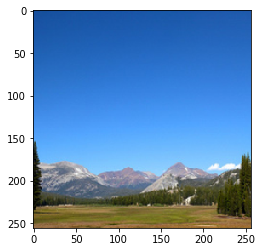

In [31]:
plt.imshow(as_test_real[0].detach().cpu().numpy().transpose(1,2,0)/2 + 0.5)

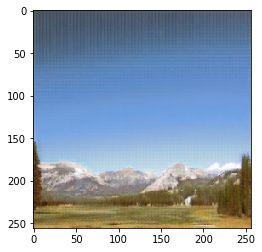

In [32]:
plt.imshow(bs_test_fake[0].detach().cpu().numpy().transpose(1,2,0)/2 + 0.5)

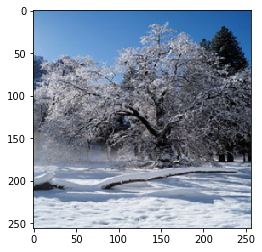

In [33]:
plt.imshow(bs_test_real[0].detach().cpu().numpy().transpose(1,2,0)/2 + 0.5)

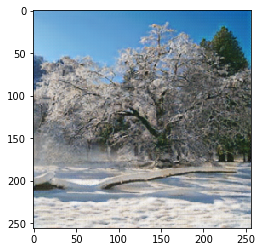

In [34]:
plt.imshow(as_test_fake[0].detach().cpu().numpy().transpose(1,2,0)/2 + 0.5)

In [12]:
a = []

In [15]:
a.append([])

In [16]:
a

[[], []]